In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

pd.set_option('display.max_columns', 32)

## Data Cleaning

In [2]:
df = pd.read_csv('/kaggle/input/hotel-booking-demand/hotel_bookings.csv')

print('DataFrame shape:', df.shape)

DataFrame shape: (119390, 32)


In [3]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
null_features = df.columns[df.isna().any()]

null_df = df[null_features].isna().sum().rename('missing values').to_frame()
null_df['percentage'] = round(null_df['missing values'] / df.shape[0] * 100, 3)
null_df['percentage'] = null_df['percentage'].astype('str')

null_df.sort_values('missing values', ascending=False).style.background_gradient('Blues')

,missing values,percentage
company,112593,94.307
agent,16340,13.686
country,488,0.409
children,4,0.003


In [5]:
df.drop(['company', 'agent'], axis=1, inplace=True)
df.drop([14969], axis=0, inplace=True)

df.dropna(subset=['country'], inplace=True)

df['children'].fillna(0.0, inplace=True)

## About duplicated rows

* Actually duplicate rows can bias prediction
* But because we have a limited dataset, this cause Deep Learning model to got worse performance
* So i decided to keep them

In [6]:
# print('Duplicated rows:', df.duplicated().sum())

# df.drop_duplicates(inplace=True)

# print('Shape after drop duplicates:', df.shape)

## correct dtypes some features # gak ada perubahan, coba check lg

In [7]:
df['arrival_date_year'] = df['arrival_date_year'].astype('category')
df['arrival_date_month'] = df['arrival_date_month'].astype('category')
df['arrival_date_week_number'] = df['arrival_date_week_number'].astype('category')
df['arrival_date_day_of_month'] = df['arrival_date_day_of_month'].astype('category')
df['is_repeated_guest'] = df['is_repeated_guest'].astype('category')

In [8]:
df.is_repeated_guest.dtypes # apakah hrs diganti ordered-nya?

CategoricalDtype(categories=[0, 1], ordered=False)

## EDA

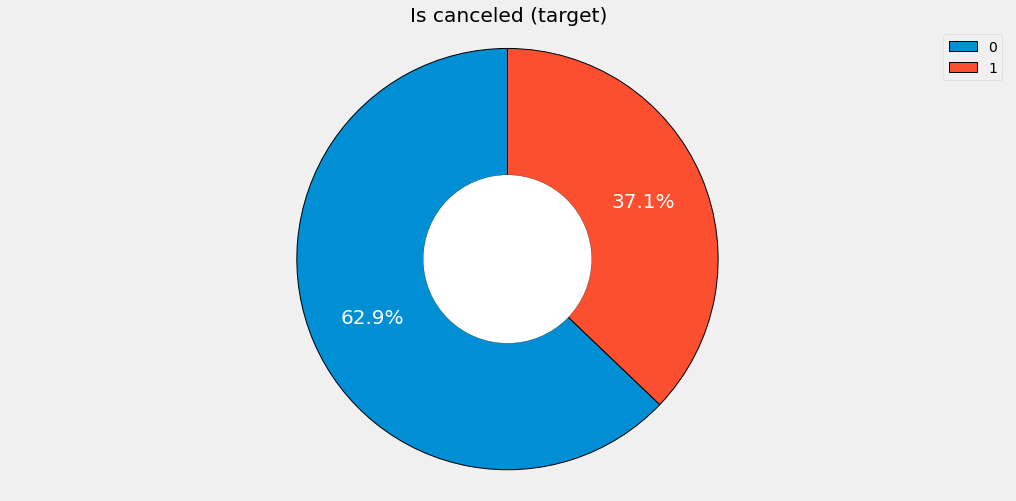

In [9]:
is_canceled = df['is_canceled'].value_counts()

fig, ax = plt.subplots()

ax.pie(is_canceled.values,
        labels=is_canceled.index,
        autopct='%1.1f%%',
        pctdistance=0.7,
        textprops={'color':"w", 'fontsize':20}, # pct color & size
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        labeldistance=None,
        startangle=90)

centre_circle = plt.Circle((0, 0), 0.4, edgecolor='black',
                          facecolor='white', fill=True, linewidth=0.25)

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Is canceled (target)')
plt.legend()
plt.axis('equal')
plt.show()

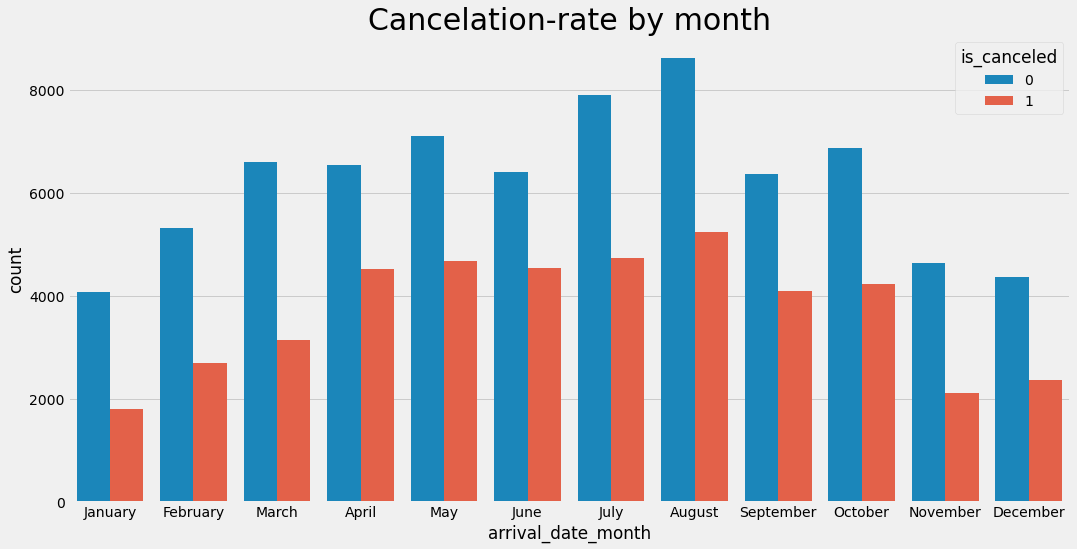

In [10]:
month_index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

sns.countplot(x='arrival_date_month',
              hue='is_canceled',
              data=df,
              order=month_index).set_title('Cancelation-rate by month', fontsize=30);

* Most users canceled their booking on August
* Cancelation-rate on July, April, June and May also high
* For detail you can see below..

In [11]:
df_canceled = df[df['is_canceled'] == 0]
df_not_canceled = df[df['is_canceled'] == 1]

cancel_not_canceled = round(df_not_canceled.groupby('arrival_date_month')['is_canceled'].count() / df_canceled.groupby('arrival_date_month')['is_canceled'].count() * 100, 2)
cancel_not_canceled.sort_values(ascending=False)

arrival_date_month
June         70.92
April        69.06
May          65.85
September    64.39
October      61.57
August       60.78
July         60.01
December     54.14
February     50.69
March        47.77
November     45.77
January      44.40
Name: is_canceled, dtype: float64

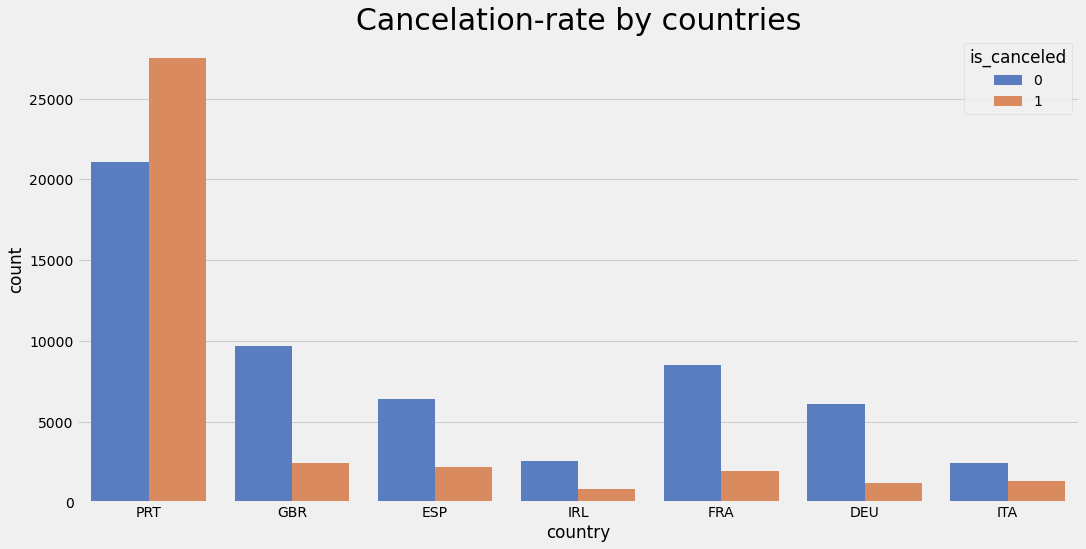

In [12]:
top_6_counties = (df['country'] == 'PRT') | (df['country'] == 'GBR') | (df['country'] == 'ESP') | (df['country'] == 'IRL') | (df['country'] == 'FRA') | (df['country'] == 'DEU') | (df['country'] == 'ITA')

df_top_6_countries = df[top_6_counties]

sns.countplot(x='country',
              hue='is_canceled',
              data=df_top_6_countries,
              palette='muted').set_title('Cancelation-rate by countries', fontsize=30);

* Based on dataset, cancelation-rate for Portugal & Italy users in high
* Perhaps other countries also high but not detected, i only plot countries with six most users

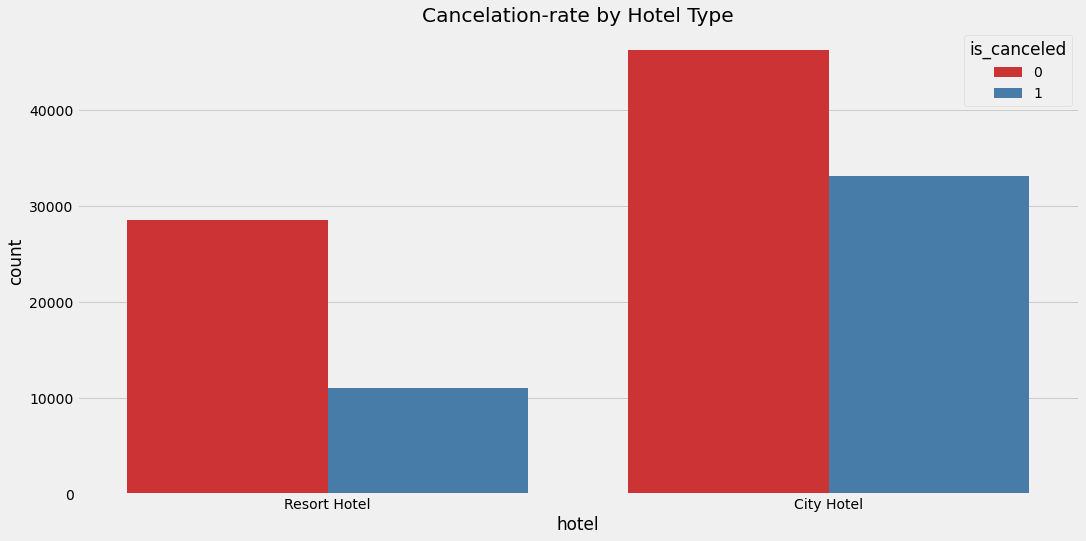

In [13]:
sns.countplot(x='hotel',
              hue='is_canceled',
              data=df,
              palette='Set1').set_title('Cancelation-rate by Hotel Type');

In [14]:
round(df_not_canceled.groupby('hotel')['is_canceled'].count() / df_canceled.groupby('hotel')['is_canceled'].count(), 2)

hotel
City Hotel      0.72
Resort Hotel    0.39
Name: is_canceled, dtype: float64

* City Hotel Cancelation-rate is higher than Resort Hotel

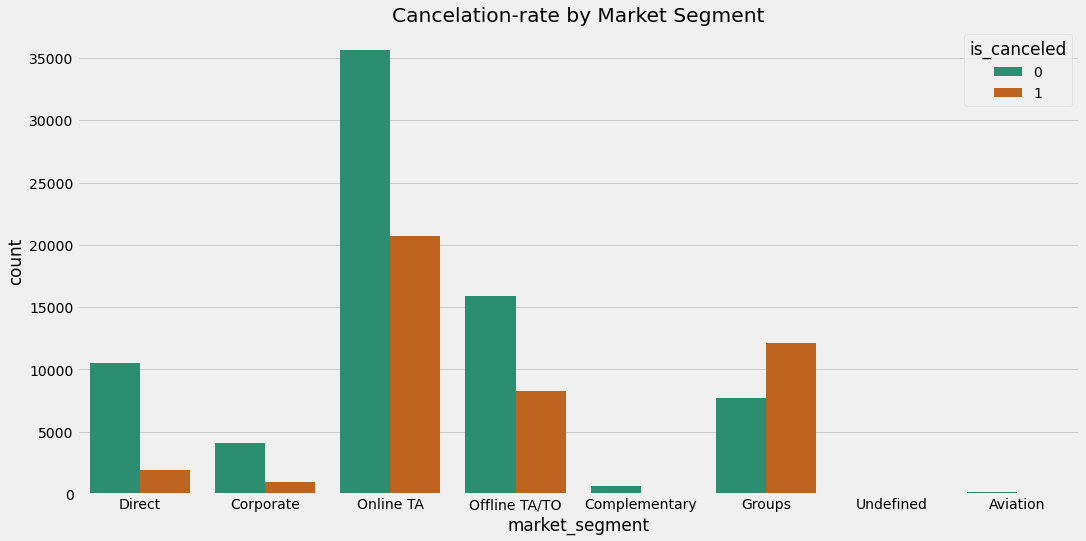

In [15]:
sns.countplot(x='market_segment',
              hue='is_canceled',
              data=df,
              palette='Dark2').set_title('Cancelation-rate by Market Segment');

* If the market segment is Online, the possibility of cancel-booking is higher than others

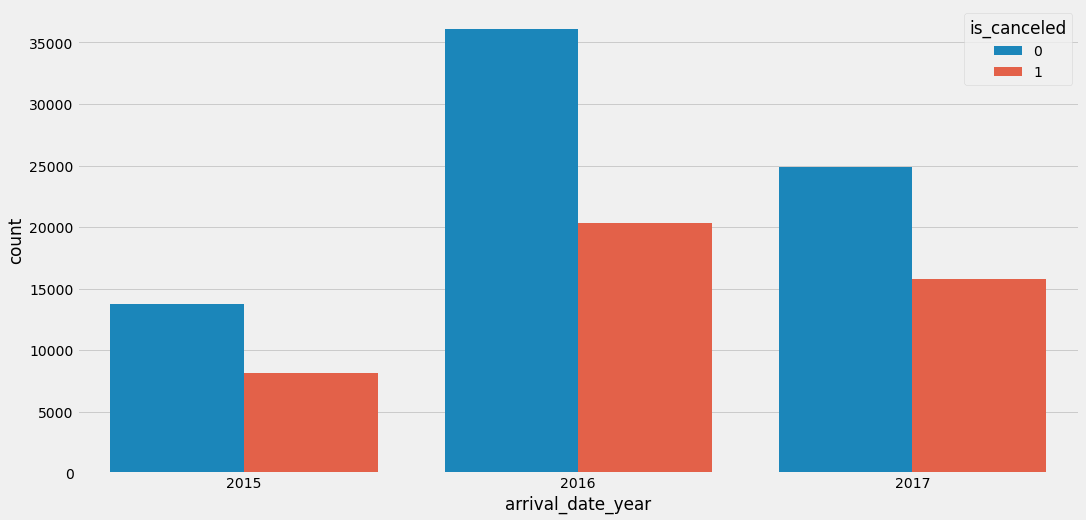

In [16]:
sns.countplot(x='arrival_date_year',
              hue='is_canceled',
              data=df);

In [17]:
round(df_not_canceled.groupby('arrival_date_year')['is_canceled'].count() / df_canceled.groupby('arrival_date_year')['is_canceled'].count(), 2).sort_values(ascending=False)

arrival_date_year
2017    0.63
2015    0.59
2016    0.56
Name: is_canceled, dtype: float64

## Correlation

The issue here is that **is_canceled** are linked with some categorical attributes so we cannot simply use "df.corr()" to accurately get the correlation matrix.

There is Cramer's V model based on the chi squared statistics that can show how strongly nominal variables are associated with one another. 

In [18]:
## the results was not good, compare with 2 other metodes below
df.corr()['is_canceled']

is_canceled                       1.000000
lead_time                         0.291947
stays_in_weekend_nights          -0.002619
stays_in_week_nights              0.024115
adults                            0.058410
children                          0.004738
babies                           -0.032524
previous_cancellations            0.109914
previous_bookings_not_canceled   -0.055488
booking_changes                  -0.144657
days_in_waiting_list              0.054008
adr                               0.046120
required_car_parking_spaces      -0.194803
total_of_special_requests        -0.235601
Name: is_canceled, dtype: float64

In [19]:
import scipy.stats as ss

In [20]:
#Functions for finding out correlation value

#Correlation measurement untuk data categorical dan continuous
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories) # _ is unique, but not use for this function
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    
    for i in range(0, cat_num):
        cat_measures = measurements.iloc[np.argwhere(fcat == i).flatten()] # pandas new version must use iloc instead only measurements[np.argwhere]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)

    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg), 2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg), 2))
    
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
        
    return eta


#Correlation measurement untuk data categorical dan categorical
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1),(rcorr-1)))

In [21]:
X = df.drop(['is_canceled'], axis=1)
X_num = X.select_dtypes(np.number)
X_cat = X.select_dtypes(include=['object', 'category'])

y = df['is_canceled']

In [22]:
list_cat_to_num_corr = []
for num in X_num.columns:
    list_cat_to_num_corr.append(correlation_ratio(y, X_num[num]))
    
list_cat_to_cat_corr = []
for cat in X_cat.columns:
    list_cat_to_cat_corr.append(cramers_v(y, X_cat[cat]))

In [23]:
df_corr1 = pd.DataFrame(list_cat_to_num_corr, index=X_num.columns, columns=['Correlation'])
df_corr1 = df_corr1.append(pd.DataFrame(list_cat_to_cat_corr, index=X_cat.columns, columns=['Correlation']))
df_corr1 = df_corr1.sort_values('Correlation', ascending=False).head(10)

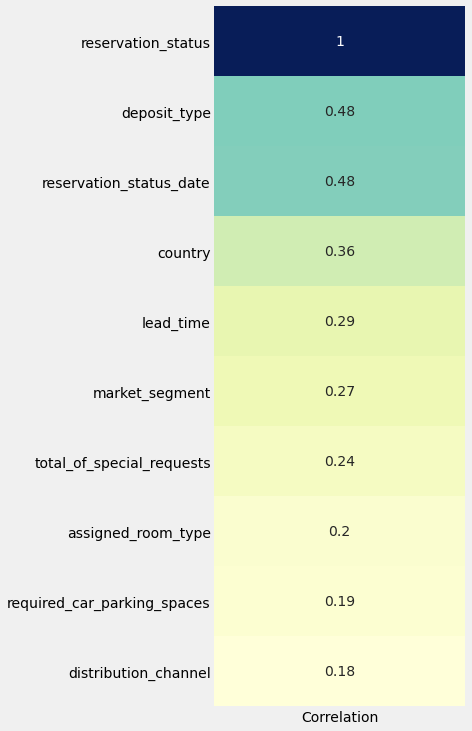

In [24]:
plt.figure(figsize = (4, 12))
sns.heatmap(df_corr1, annot = True, cmap="YlGnBu", cbar=False)
plt.show()

## Univariate - chi2 method

In [25]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for cat in X_cat.columns:
    X[cat] = encoder.fit_transform(X[cat])

In [26]:
from sklearn.feature_selection import SelectKBest, chi2

kbest = SelectKBest(chi2, k=10)
kbest.fit(X, y)

dfscores = pd.DataFrame(X.columns, columns=['features'])
dfscores['scores'] = kbest.scores_

dfscores_final = dfscores.nlargest(10, 'scores')
dfscores_final

,features,scores
1,lead_time,1.110343e+06
28,reservation_status_date,3.164592e+05
12,country,1.863945e+05
22,days_in_waiting_list,4.625114e+04
27,reservation_status,3.824500e+04
21,deposit_type,2.339223e+04
16,previous_cancellations,1.179414e+04
19,assigned_room_type,9.761581e+03
26,total_of_special_requests,7.253620e+03
24,adr,6.319798e+03


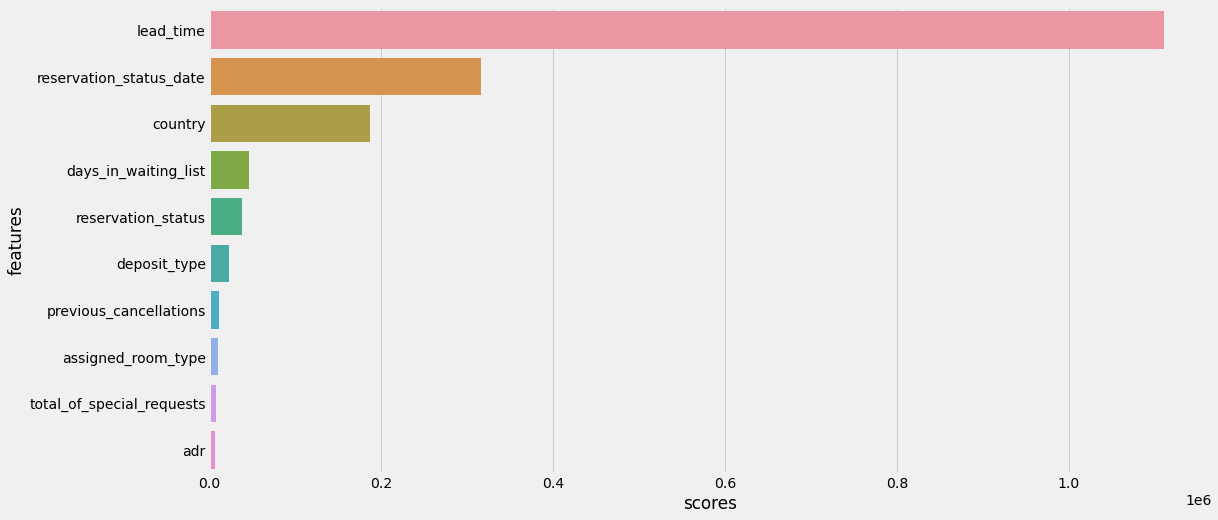

In [27]:
sns.barplot(x=dfscores_final['scores'],
            y=dfscores_final['features']);

## Kesimpulan

* Metode 1 - correlation lebih bisa menangkap categorical features disini
* Tetapi tetap hrs dicheck, seperti di kasus fariz malahan lebih bagus metode ke-2
* In the end, hrs dicheck lg pakai EDA keduanya

In [28]:
# use reservation_status will give val_accuracy 1.0 directly

In [29]:
final_df = df[['deposit_type', 'reservation_status_date',
           'country', 'lead_time', 'market_segment', 'total_of_special_requests',
           'assigned_room_type', 'required_car_parking_spaces',
           'distribution_channel']]

In [30]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_num_scaled = scaler.fit_transform(final_df[['lead_time']])

In [31]:
final_df = final_df.drop(['lead_time'], axis=1)

X_cat_onehot = pd.get_dummies(data=final_df)

In [32]:
X_final = np.concatenate([X_cat_onehot.values, X_num_scaled], axis=1)
y_final = df['is_canceled']

In [33]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, stratify=y_final, test_size=0.20, random_state=7)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((95120, 1134), (23781, 1134), (95120,), (23781,))

## First, try Random Forest & XGB

In [71]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [81]:
rfc = RandomForestClassifier(max_depth=15, n_estimators=3500, n_jobs=-1, class_weight='balanced', random_state=7)
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=3500,
                       n_jobs=-1, random_state=7)

In [82]:
rf_predict = rfc.predict(X_test)

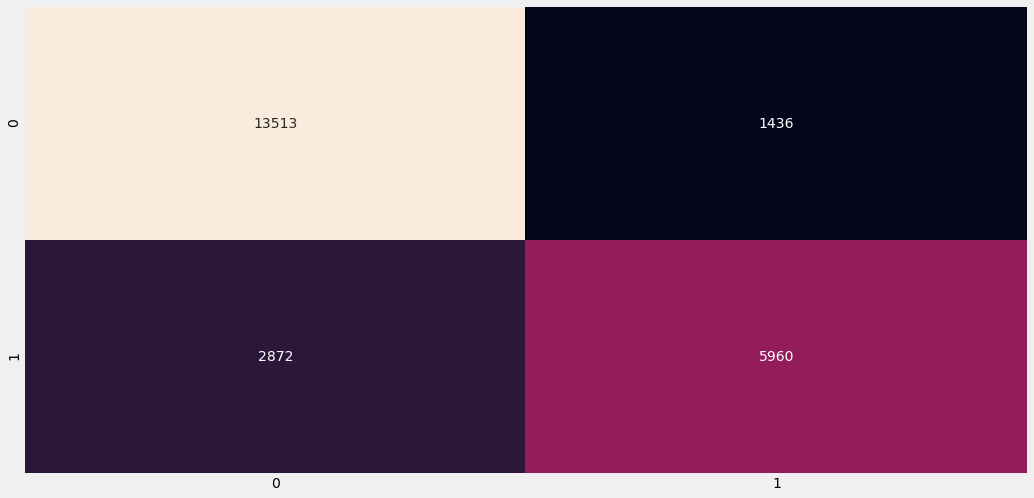

In [83]:
from sklearn.metrics import classification_report, confusion_matrix

sns.heatmap(confusion_matrix(y_test, rf_predict), annot=True, fmt='.0f', cbar=False);

In [84]:
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86     14949
           1       0.81      0.67      0.73      8832

    accuracy                           0.82     23781
   macro avg       0.82      0.79      0.80     23781
weighted avg       0.82      0.82      0.81     23781



In [76]:
xgb = XGBClassifier(subsample = 0.5,
                    reg_alpha = 0.01,
                    n_estimators = 800,
                    min_child_weight = 5,
                    max_depth = 5,
                    learning_re = 0.02,
                    gamma = 0.0,
                    colsample_bytree = 0.80)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=800, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [77]:
xgb_predict = xgb.predict(X_test)

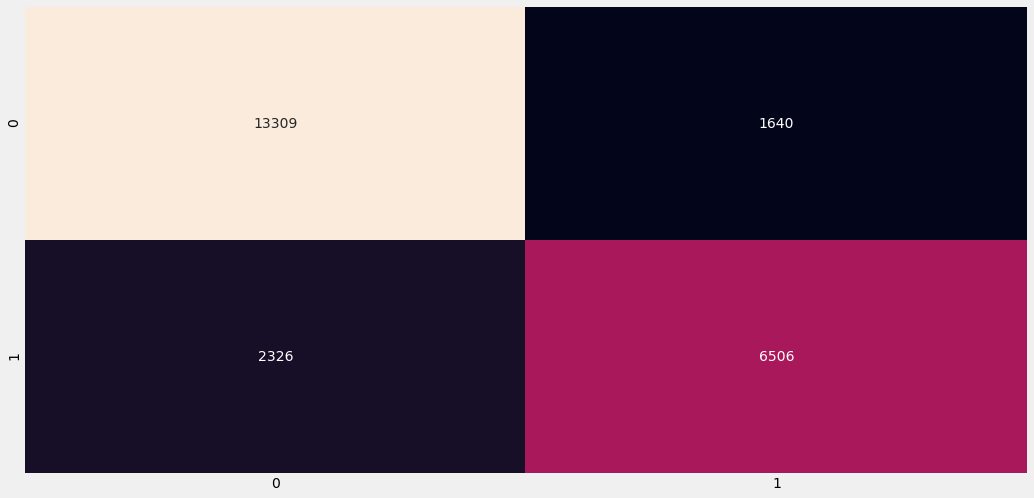

In [78]:
sns.heatmap(confusion_matrix(y_test, xgb_predict), annot=True, fmt='.0f', cbar=False);

In [79]:
print(classification_report(y_test, xgb_predict))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87     14949
           1       0.80      0.74      0.77      8832

    accuracy                           0.83     23781
   macro avg       0.82      0.81      0.82     23781
weighted avg       0.83      0.83      0.83     23781



## Then let's compare with Neural Networks

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.2.0


In [35]:
model = Sequential()

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [36]:
checkpoint1 = ModelCheckpoint('model1.h5', monitor='val_loss', verbose=0, save_best_only=True)

In [37]:
history1 = model.fit(x=X_train, 
          y=y_train, 
          epochs=25,
          batch_size=32,
          validation_data=(X_test, y_test),
          verbose=1, 
          callbacks=[checkpoint1]
)

Epoch 1/25
2973/2973 [==============================] - 7s 2ms/step - loss: 0.4625 - accuracy: 0.7850 - val_loss: 0.3455 - val_accuracy: 0.8373
Epoch 2/25
2973/2973 [==============================] - 7s 2ms/step - loss: 0.3846 - accuracy: 0.8253 - val_loss: 0.3256 - val_accuracy: 0.8447
Epoch 3/25
2973/2973 [==============================] - 7s 2ms/step - loss: 0.3704 - accuracy: 0.8311 - val_loss: 0.3184 - val_accuracy: 0.8497
Epoch 4/25
2973/2973 [==============================] - 9s 3ms/step - loss: 0.3599 - accuracy: 0.8375 - val_loss: 0.3066 - val_accuracy: 0.8576
Epoch 5/25
2973/2973 [==============================] - 7s 2ms/step - loss: 0.3537 - accuracy: 0.8418 - val_loss: 0.3043 - val_accuracy: 0.8607
Epoch 6/25
2973/2973 [==============================] - 7s 2ms/step - loss: 0.3491 - accuracy: 0.8442 - val_loss: 0.3018 - val_accuracy: 0.8616
Epoch 7/25
2973/2973 [==============================] - 7s 2ms/step - loss: 0.3450 - accuracy: 0.8461 - val_loss: 0.3051 - val_accuracy:

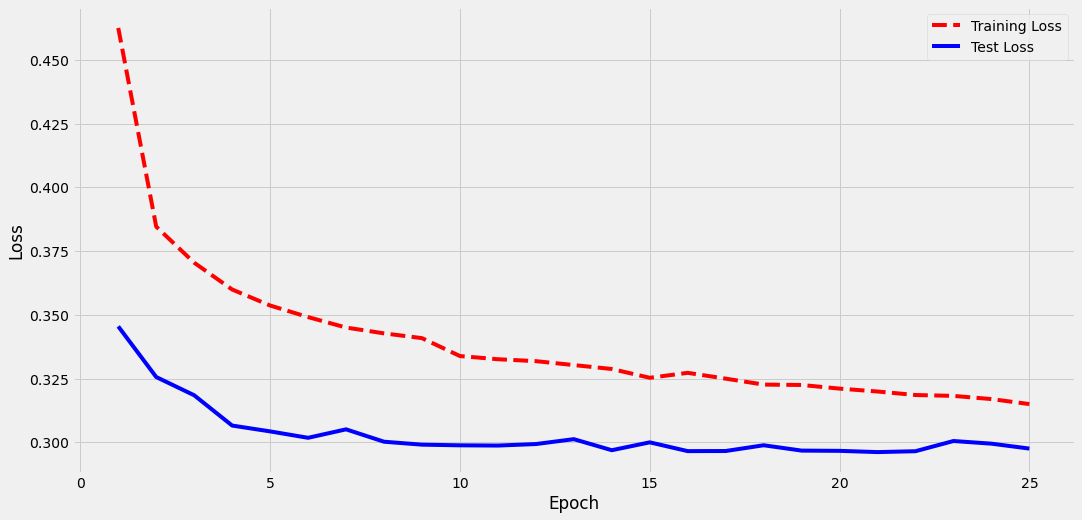

In [38]:
# Get training and test loss histories
training_loss1 = history1.history['loss']
test_loss1 = history1.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss1) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss1, 'r--')
plt.plot(epoch_count, test_loss1, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [53]:
from tensorflow.keras.models import load_model

model_1 = load_model('model1.h5')

In [54]:
predictions = model_1.predict_classes(X_test)

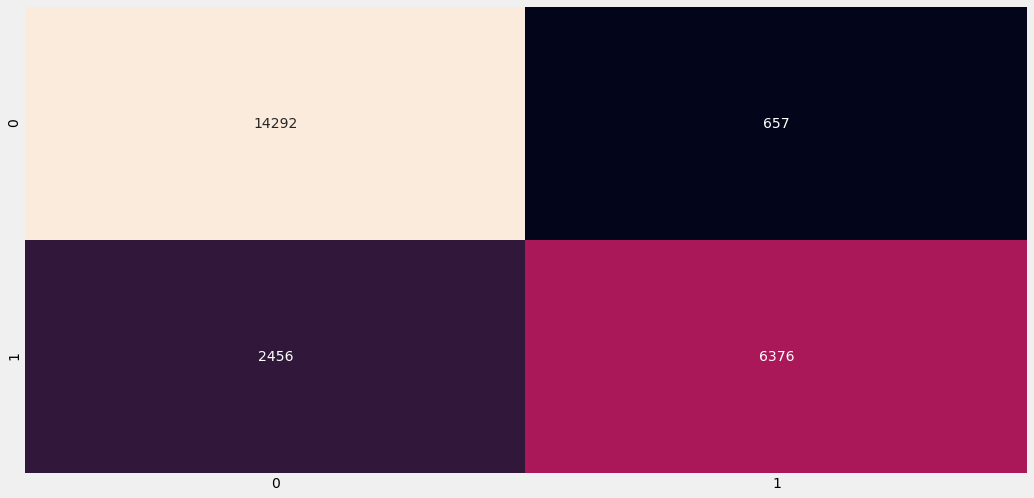

In [68]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='.0f', cbar=False);

In [56]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     14949
           1       0.91      0.72      0.80      8832

    accuracy                           0.87     23781
   macro avg       0.88      0.84      0.85     23781
weighted avg       0.87      0.87      0.87     23781



## Try SMOTE

![SMOTE](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)

* The original paper on SMOTE suggested combining SMOTE with random undersampling of the majority class.
* Since we have very little dataset, we couldn't do that in here

In [85]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [86]:
## increase is_canceled (1) class to 85%

smote = SMOTE(sampling_strategy=0.85, random_state = 23)
X_smoted, y_smoted = smote.fit_sample(X_train, y_train)

In [89]:
print('Target variable shape after Oversampling (SMOTE) {}'.format(Counter(y_smoted)))

print('Percentage:', round(50825 / 59795, 2))

Target variable shape after Oversampling (SMOTE) Counter({0: 59795, 1: 50825})
Percentage: 0.85


In [90]:
checkpoint1 = ModelCheckpoint('model2.h5', monitor='val_loss', verbose=0, save_best_only=True)

In [91]:
checkpoint2 = ModelCheckpoint('model2.h5', monitor='val_loss', verbose=0, save_best_only=True)

history2 = model.fit(x=X_smoted, 
          y=y_smoted, 
          epochs=30,
          batch_size=32,
          validation_data=(X_test, y_test),
          verbose=1, 
          callbacks=[checkpoint2]
)

Epoch 1/30
3457/3457 [==============================] - 8s 2ms/step - loss: 0.3153 - accuracy: 0.8414 - val_loss: 0.3100 - val_accuracy: 0.8715
Epoch 2/30
3457/3457 [==============================] - 8s 2ms/step - loss: 0.3131 - accuracy: 0.8432 - val_loss: 0.3075 - val_accuracy: 0.8711
Epoch 3/30
3457/3457 [==============================] - 8s 2ms/step - loss: 0.3179 - accuracy: 0.8407 - val_loss: 0.3016 - val_accuracy: 0.8707
Epoch 4/30
3457/3457 [==============================] - 8s 2ms/step - loss: 0.3137 - accuracy: 0.8426 - val_loss: 0.3033 - val_accuracy: 0.8723
Epoch 5/30
3457/3457 [==============================] - 8s 2ms/step - loss: 0.3155 - accuracy: 0.8417 - val_loss: 0.3098 - val_accuracy: 0.8720
Epoch 6/30
3457/3457 [==============================] - 8s 2ms/step - loss: 0.3130 - accuracy: 0.8424 - val_loss: 0.3093 - val_accuracy: 0.8714
Epoch 7/30
3457/3457 [==============================] - 8s 2ms/step - loss: 0.3139 - accuracy: 0.8415 - val_loss: 0.3079 - val_accuracy:

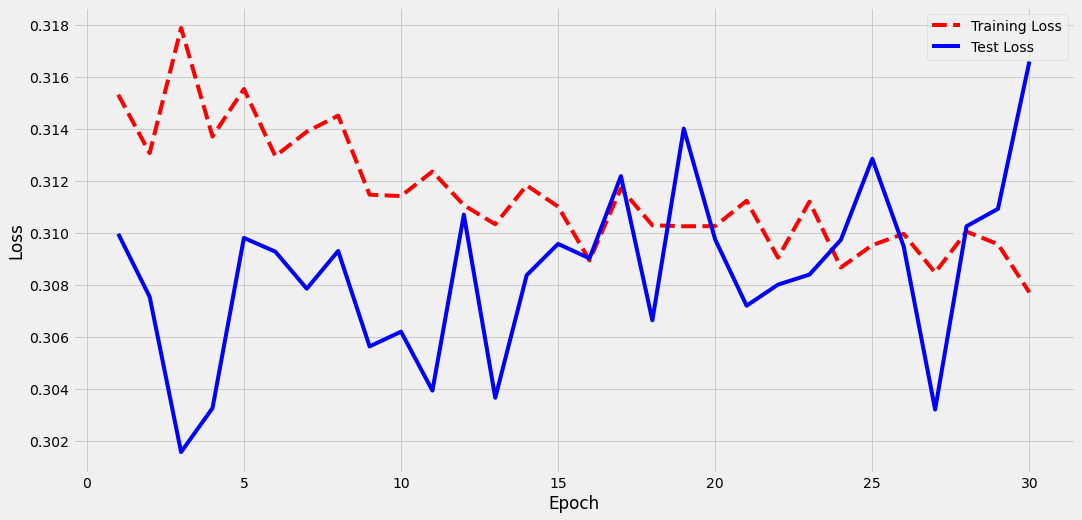

In [92]:
# Get training and test loss histories
training_loss2 = history2.history['loss']
test_loss2 = history2.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss2) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss2, 'r--')
plt.plot(epoch_count, test_loss2, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [93]:
model_2 = load_model('model2.h5')

predictions2 = model_2.predict_classes(X_test)

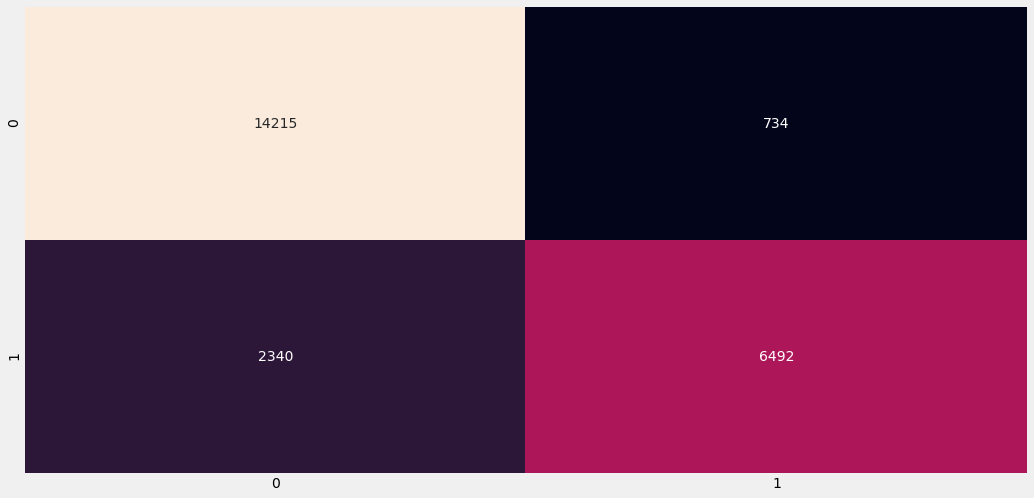

In [94]:
sns.heatmap(confusion_matrix(y_test, predictions2), annot=True, fmt='.0f', cbar=False);

In [95]:
print(classification_report(y_test, predictions2))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     14949
           1       0.90      0.74      0.81      8832

    accuracy                           0.87     23781
   macro avg       0.88      0.84      0.86     23781
weighted avg       0.87      0.87      0.87     23781



### Result: This SMOTE model increase recall by 2% but decrease precision by 1% (trade-off)

## References

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

https://www.sciencedirect.com/science/article/pii/S2352340918315191